# 蒙特卡洛算法

## 1、定义算法

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
from collections import defaultdict
class FisrtVisitMC:
    ''' On-Policy First-Visit MC Control
    '''
    def __init__(self,cfg):
        self.n_actions = cfg.n_actions
        self.epsilon = cfg.epsilon
        self.gamma = cfg.gamma 
        self.Q_table = defaultdict(lambda: np.zeros(cfg.n_actions))
        self.returns_sum = defaultdict(float) # 保存return之和
        self.returns_count = defaultdict(float)
        
    def sample_action(self,state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_probs[best_action] += (1.0 - self.epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        else:
            action = np.random.randint(0,self.n_actions)
        return action
    def predict_action(self,state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_probs[best_action] += (1.0 - self.epsilon)
            action = np.argmax(self.Q_table[state])
        else:
            action = np.random.randint(0,self.n_actions)
        return action
    def update(self,one_ep_transition):
        # Find all (state, action) pairs we've visited in this one_ep_transition
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(str(x[0]), x[1]) for x in one_ep_transition])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurence of the (state, action) pair in the one_ep_transition

            first_occurence_idx = next(i for i,x in enumerate(one_ep_transition)
                                       if str(x[0]) == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(self.gamma**i) for i,x in enumerate(one_ep_transition[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            self.returns_sum[sa_pair] += G
            self.returns_count[sa_pair] += 1.0
            self.Q_table[state][action] = self.returns_sum[sa_pair] / self.returns_count[sa_pair]

## 2、定义训练

In [8]:
def train(cfg,env,agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}, 设备:{cfg.device}')
    rewards = []  # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        one_ep_transition = []
        state = env.reset(seed=cfg.seed) # 重置环境,即开始新的回合
        for _ in range(cfg.max_steps):
            action = agent.sample_action(state)  # 根据算法采样一个动作
            next_state, reward, terminated, info = env.step(action)   # 与环境进行一次动作交互
            one_ep_transition.append((state, action, reward))  # 保存transitions
            agent.update(one_ep_transition)  # 更新智能体
            state = next_state  # 更新状态
            ep_reward += reward  
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}")
    print('完成训练！')
    return {"rewards":rewards}

def test(cfg,env,agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
        for _ in range(cfg.max_steps):
            action = agent.predict_action(state)  # 根据算法选择一个动作
            next_state, reward, terminated, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return {"rewards":rewards}

## 3、定义环境

In [9]:
import sys,os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
import torch
import numpy as np
import random
from envs.racetrack import RacetrackEnv

def all_seed(env,seed = 1):
    ''' omnipotent seed for RL, attention the position of seed function, you'd better put it just following the env create function
    '''
    if seed == 0:
        return
    # print(f"seed = {seed}")
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
def env_agent_config(cfg):
    '''创建环境和智能体
    '''    
    env = RacetrackEnv()  # 创建环境
    all_seed(env,seed=cfg.seed) 
    n_states = env.observation_space.shape[0]  # 状态空间维度
    n_actions = env.action_space.n # 动作空间维度
    setattr(cfg, 'n_states', n_states) # 将状态维度添加到配置参数中
    setattr(cfg, 'n_actions', n_actions) # 将动作维度添加到配置参数中
    agent = FisrtVisitMC(cfg)
    return env,agent

## 4、设置参数

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    '''配置参数
    '''
    def __init__(self):
        self.env_name = 'Racetrack-v0' # 环境名称
        self.algo_name = "FirstVisitMC" # 算法名称
        self.train_eps = 100 # 训练回合数
        self.test_eps = 20 # 测试回合数
        self.max_steps = 200 # 每个回合最大步数
        self.epsilon = 0.1 # 贪婪度
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.5 # 学习率
        self.seed = 1 # 随机种子
        # if torch.cuda.is_available(): # 是否使用GPUs
        #     self.device = torch.device('cuda')
        # else:
        #     self.device = torch.device('cpu')
        self.device = torch.device('cpu')
def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5、开始训练

开始训练！
环境:Racetrack-v0, 算法:FirstVisitMC, 设备:cpu
回合：1/100，奖励：-680.0
回合：2/100，奖励：-510.0
回合：3/100，奖励：-360.0
回合：4/100，奖励：-440.0
回合：5/100，奖励：-410.0
回合：6/100，奖励：-380.0
回合：7/100，奖励：-400.0
回合：8/100，奖励：-360.0
回合：9/100，奖励：-360.0
回合：10/100，奖励：-350.0
回合：11/100，奖励：-320.0
回合：12/100，奖励：-380.0
回合：13/100，奖励：-360.0
回合：14/100，奖励：-350.0
回合：15/100，奖励：-310.0
回合：16/100，奖励：-310.0
回合：17/100，奖励：-340.0
回合：18/100，奖励：-84.0
回合：19/100，奖励：-310.0
回合：20/100，奖励：-104.0
回合：21/100，奖励：-370.0
回合：22/100，奖励：-330.0
回合：23/100，奖励：-350.0
回合：24/100，奖励：-350.0
回合：25/100，奖励：-380.0
回合：26/100，奖励：-410.0
回合：27/100，奖励：-310.0
回合：28/100，奖励：-260.0
回合：29/100，奖励：-21.0
回合：30/100，奖励：-310.0
回合：31/100，奖励：-350.0
回合：32/100，奖励：-400.0
回合：33/100，奖励：-290.0
回合：34/100，奖励：-340.0
回合：35/100，奖励：-320.0
回合：36/100，奖励：-360.0
回合：37/100，奖励：-262.0
回合：38/100，奖励：-370.0
回合：39/100，奖励：-69.0
回合：40/100，奖励：-170.0
回合：41/100，奖励：-310.0
回合：42/100，奖励：-300.0
回合：43/100，奖励：-280.0
回合：44/100，奖励：-310.0
回合：45/100，奖励：-320.0
回合：46/100，奖励：-320.0
回合：47/100，奖励：-330.0
回合：48/100，奖励：-330.0
回合：49

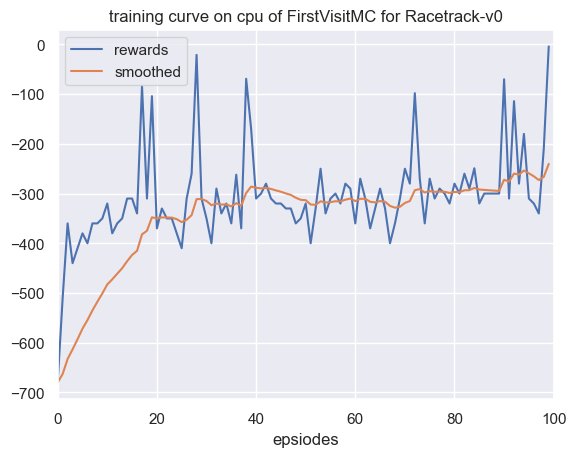

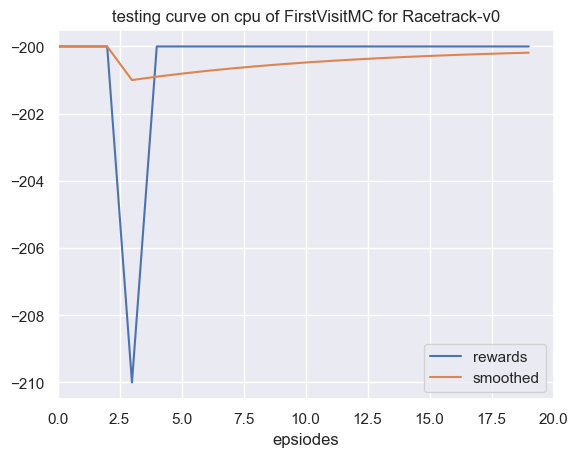

In [11]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果